# ML в Биологии
## 2. Введение в нейронные сети и оптимизацию

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import shutil

import torch
from torch import nn
import torchvision
from torchvision import transforms
from sklearn.metrics import f1_score
from sklearn.utils.random import sample_without_replacement
from IPython.display import Image, clear_output
from collections import defaultdict
from torch.optim import lr_scheduler
from matplotlib.animation import FuncAnimation, ImageMagickFileWriter
import time
from sklearn.model_selection import train_test_split

%matplotlib inline

### Задача 1.

* Реализуйте обучение и тестирование нейронной сети из прошлого домашнего задания с использованием PyTorch Lightning и Tensorboard.
* Улучшите архитектуру сети с учетом новых знаний.
* Проведите минимум 7 экспериментов для определения наилучших параметров обучения. Например, можно менять вероятность отключения нейронов в слоях Dropout, число нейронов на скрытых слоях, learning rate. Возможно, вы захотите воспользоваться learning rate scheduler, а также проверить разные оптимизаторы.

**Полезные ссылки:**
[Lightning callbacks](https://lightning.ai/docs/pytorch/stable/extensions/callbacks.html)
[Lightning learning rate schedulers](https://pytorch.org/docs/2.4/optim.html#how-to-adjust-learning-rate)

**Далее идёт предобработка биологического датасета, которую можно удалить, если вы работаете с физическим. После этого блока (см. ниже) идёт общая часть с созданием, обучением и тестированием нейросети.**

#### Профиль биология

Скачайте [датасет](https://disk.yandex.ru/d/FVoQGn5q1td7Vw), описывающий влияние курения и алкоголя на человека. Создайте и обучите нейросеть, разделяющую эти два класса.

[Описание датасета](https://www.kaggle.com/datasets/sooyoungher/smoking-drinking-dataset)

Всю предобработку я позаимвствую из предыдущего ДЗ

In [ ]:
!unzip /content/smoking_drinking_dataset.zip

Archive:  /content/smoking_drinking_dataset.zip
  inflating: smoking_driking_dataset_Ver01.csv  


In [ ]:
df = pd.read_csv('smoking_driking_dataset_Ver01.csv')
df.head()

,sex,age,height,weight,waistline,sight_left,sight_right,hear_left,hear_right,SBP,...,LDL_chole,triglyceride,hemoglobin,urine_protein,serum_creatinine,SGOT_AST,SGOT_ALT,gamma_GTP,SMK_stat_type_cd,DRK_YN
0,Male,35,170,75,90.0,1.0,1.0,1.0,1.0,120.0,...,126.0,92.0,17.1,1.0,1.0,21.0,35.0,40.0,1.0,Y
1,Male,30,180,80,89.0,0.9,1.2,1.0,1.0,130.0,...,148.0,121.0,15.8,1.0,0.9,20.0,36.0,27.0,3.0,N
2,Male,40,165,75,91.0,1.2,1.5,1.0,1.0,120.0,...,74.0,104.0,15.8,1.0,0.9,47.0,32.0,68.0,1.0,N
3,Male,50,175,80,91.0,1.5,1.2,1.0,1.0,145.0,...,104.0,106.0,17.6,1.0,1.1,29.0,34.0,18.0,1.0,N
4,Male,50,165,60,80.0,1.0,1.2,1.0,1.0,138.0,...,117.0,104.0,13.8,1.0,0.8,19.0,12.0,25.0,1.0,N


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 991346 entries, 0 to 991345
Data columns (total 24 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   sex               991346 non-null  object 
 1   age               991346 non-null  int64  
 2   height            991346 non-null  int64  
 3   weight            991346 non-null  int64  
 4   waistline         991346 non-null  float64
 5   sight_left        991346 non-null  float64
 6   sight_right       991346 non-null  float64
 7   hear_left         991346 non-null  float64
 8   hear_right        991346 non-null  float64
 9   SBP               991346 non-null  float64
 10  DBP               991346 non-null  float64
 11  BLDS              991346 non-null  float64
 12  tot_chole         991346 non-null  float64
 13  HDL_chole         991346 non-null  float64
 14  LDL_chole         991346 non-null  float64
 15  triglyceride      991346 non-null  float64
 16  hemoglobin        99

Видно, что объекты класса `'sex'` принадлежат типу `'object'`. Заменим `Male` на 1, `Female` на 0:

In [ ]:
df['sex'][df['sex'] == 'Male'] = 1
df['sex'][df['sex'] == 'Female'] = 0
df.head()

<ipython-input-8-4d39d1badf14>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sex'][df['sex'] == 'Male'] = 1
<ipython-input-8-4d39d1badf14>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sex'][df['sex'] == 'Female'] = 0


,sex,age,height,weight,waistline,sight_left,sight_right,hear_left,hear_right,SBP,...,LDL_chole,triglyceride,hemoglobin,urine_protein,serum_creatinine,SGOT_AST,SGOT_ALT,gamma_GTP,SMK_stat_type_cd,DRK_YN
0,1,35,170,75,90.0,1.0,1.0,1.0,1.0,120.0,...,126.0,92.0,17.1,1.0,1.0,21.0,35.0,40.0,1.0,Y
1,1,30,180,80,89.0,0.9,1.2,1.0,1.0,130.0,...,148.0,121.0,15.8,1.0,0.9,20.0,36.0,27.0,3.0,N
2,1,40,165,75,91.0,1.2,1.5,1.0,1.0,120.0,...,74.0,104.0,15.8,1.0,0.9,47.0,32.0,68.0,1.0,N
3,1,50,175,80,91.0,1.5,1.2,1.0,1.0,145.0,...,104.0,106.0,17.6,1.0,1.1,29.0,34.0,18.0,1.0,N
4,1,50,165,60,80.0,1.0,1.2,1.0,1.0,138.0,...,117.0,104.0,13.8,1.0,0.8,19.0,12.0,25.0,1.0,N


Проанализируйте датасет, разделяя его по:
* курит &mdash; 3
* курил, но бросил &mdash; 2
* никогда не курил &mdash; 1

Проведем поверхностный анализ, построив гистограмму:

In [ ]:
smokers = df[df.SMK_stat_type_cd == 3].shape[0]
past_smokers = df[df.SMK_stat_type_cd == 2].shape[0]
no_smokers = df[df.SMK_stat_type_cd == 1].shape[0]

labels = ['smokers', 'past_smokers', 'no_smokers']
values = [smokers, past_smokers, no_smokers]

<ipython-input-10-9d6a42d74648>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = labels, y = values, palette = ['blue', 'green', 'orange'])


Text(0.5, 1.0, 'Smoking Status Distribution')

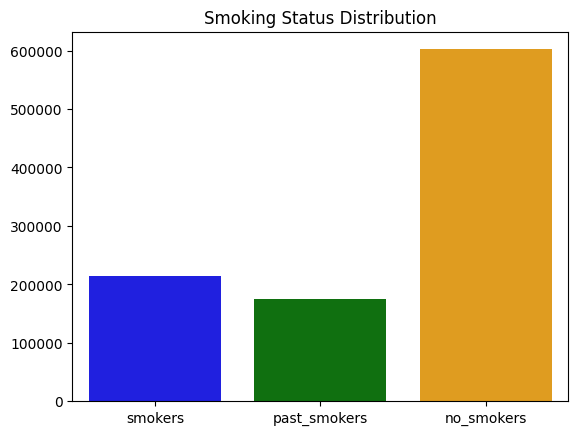

In [ ]:
sns.barplot(x = labels, y = values, palette = ['blue', 'green', 'orange'])
plt.title('Smoking Status Distribution')

**Вывод:**

Так как нам предстоит проклассифицировать людей с плохими привычками и без них, то нам нужно будет решить задачу бинарной классификации. Исходя из поверхностного анализа, предлагаю объединить курильщиков и бывших курильщиков в одну группу. Тогда наши классы будут вполне всбалансированы.

Попробуем классифицировать людей с плохими привычками и без них. Для этого создайте дополнительный столбец в таблице, который будет содержать информацию о том, имеет ли человек вредные привычки или нет.

**Невероятно, но факт:** употребление алкоголя/пьянство - это плохая привычка!

Поэтому предлагаю создать столбец `Bad_habits` следующим образом:

*   Пьющие, курящие и бросившие курить люди - `True`
*   Непьющие и некурящие - `False`

In [ ]:
df['SMK_stat_type_cd'][df['SMK_stat_type_cd'] == 1] = False
df['SMK_stat_type_cd'][df['SMK_stat_type_cd'] == 2] = True
df['SMK_stat_type_cd'][df['SMK_stat_type_cd'] == 3] = True

df['DRK_YN'][df['DRK_YN'] == 'Y'] = True
df['DRK_YN'][df['DRK_YN'] == 'N'] = False

df['Bad_habits'] = df['SMK_stat_type_cd'] | df['DRK_YN']

df.head()

<ipython-input-11-2ff3d2a8bc19>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SMK_stat_type_cd'][df['SMK_stat_type_cd'] == 1] = False
<ipython-input-11-2ff3d2a8bc19>:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df['SMK_stat_type_cd'][df['SMK_stat_type_cd'] == 1] = False
<ipython-input-11-2ff3d2a8bc19>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DRK_YN'][df['DRK_YN'] == 'Y'] = True
<ipython-input-11-2ff3d2a8bc19>:6: SettingWithCopyWa

,sex,age,height,weight,waistline,sight_left,sight_right,hear_left,hear_right,SBP,...,triglyceride,hemoglobin,urine_protein,serum_creatinine,SGOT_AST,SGOT_ALT,gamma_GTP,SMK_stat_type_cd,DRK_YN,Bad_habits
0,1,35,170,75,90.0,1.0,1.0,1.0,1.0,120.0,...,92.0,17.1,1.0,1.0,21.0,35.0,40.0,False,True,True
1,1,30,180,80,89.0,0.9,1.2,1.0,1.0,130.0,...,121.0,15.8,1.0,0.9,20.0,36.0,27.0,True,False,True
2,1,40,165,75,91.0,1.2,1.5,1.0,1.0,120.0,...,104.0,15.8,1.0,0.9,47.0,32.0,68.0,False,False,False
3,1,50,175,80,91.0,1.5,1.2,1.0,1.0,145.0,...,106.0,17.6,1.0,1.1,29.0,34.0,18.0,False,False,False
4,1,50,165,60,80.0,1.0,1.2,1.0,1.0,138.0,...,104.0,13.8,1.0,0.8,19.0,12.0,25.0,False,False,False


Теперь смотрим на разделение по привычкам

<ipython-input-12-fd9bf7f1c55d>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = labels, y = [bad, good], palette = ['green', 'orange'])


Text(0.5, 1.0, 'Habitis Status Distribution')

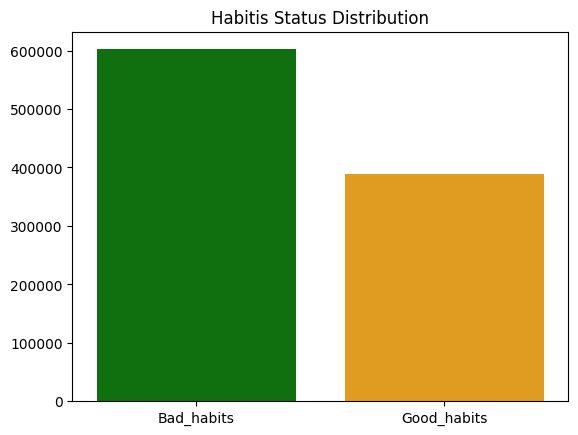

In [ ]:
bad = df[df.Bad_habits == 1].shape[0]
good = df[df.Bad_habits == 0].shape[0]

labels = ['Bad_habits', 'Good_habits']

sns.barplot(x = labels, y = [bad, good], palette = ['green', 'orange'])
plt.title('Habitis Status Distribution')

**Вывод:**

Сильного дисбаланса не наблюдается. Жить можно.

Какие признаки вы бы использовали для разделения людей по классам? Выберите эти столбцы и создайте наборы train и test с помощью функции train_test_split, а также выделите набор данных для валидации при обучении.

Так как фичей у нас не очень много, то можно посмотреть на матрицу корреляций между признакми, где особое внимание обратим на корреляцию столбца `True` с остальными признаками:

<Axes: >

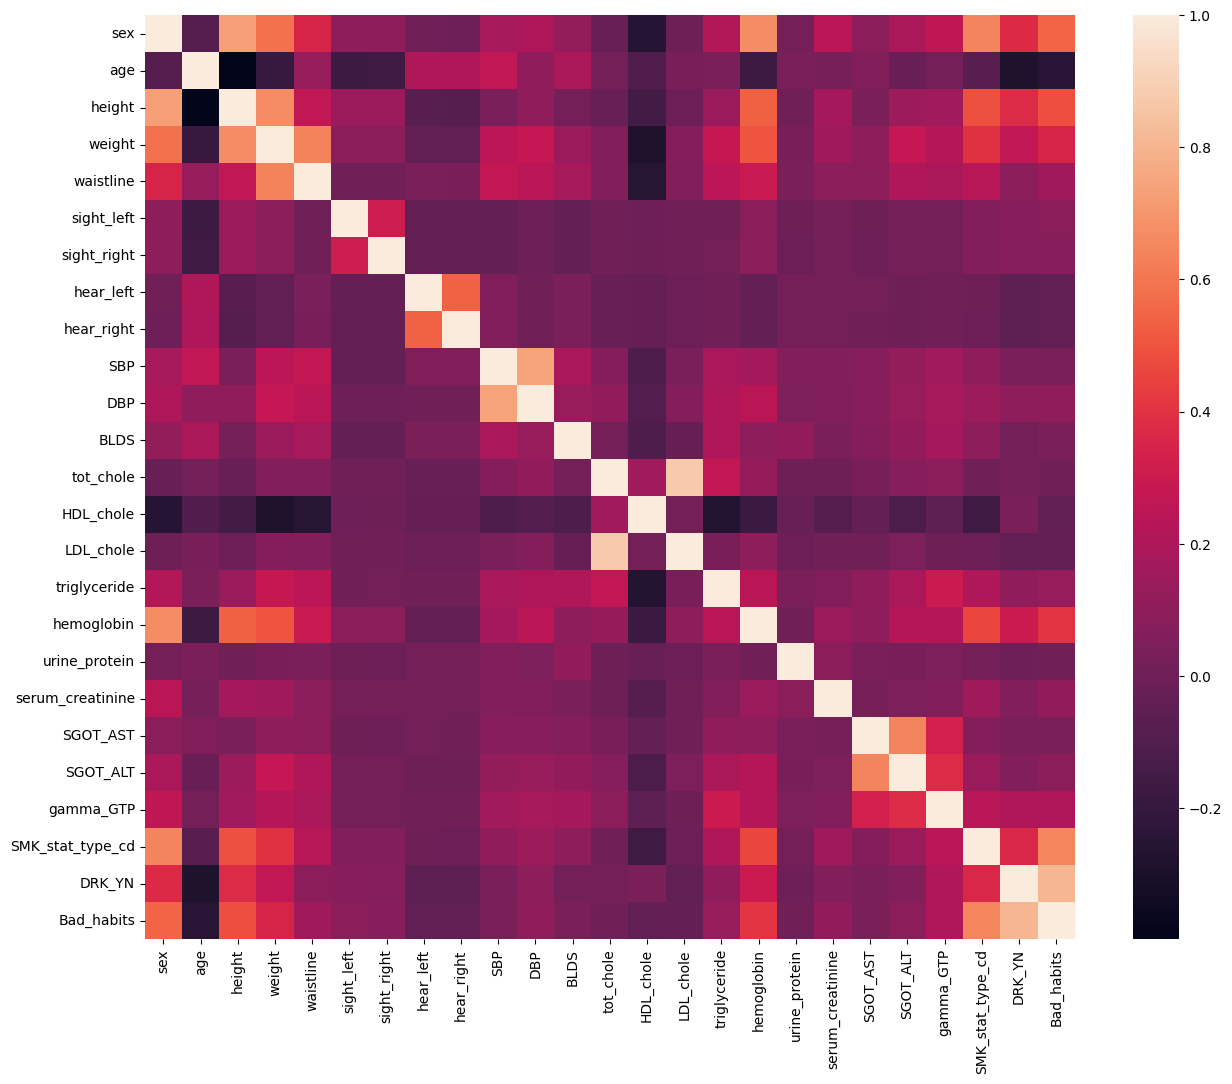

In [ ]:
corr = df[df.columns].corr()

plt.figure(figsize = (15, 12))

sns.heatmap(corr, xticklabels = corr.columns.values, yticklabels = corr.columns.values)

Выведем списки корреляций признаков со столбцом `Bad_habits`:

In [ ]:
cor = df.corr()['Bad_habits']

# Сильная корреляция (0.7 <= r)
strong = cor[abs(cor) >= 0.7].index.tolist()

# Средняя корреляция (0.5 <= r < 0.7)
medium = cor[(abs(cor) >= 0.5) & (abs(cor) < 0.7)].index.tolist()

# Умеренная корреляция (0.3 <= r < 0.5)
moderate = cor[(abs(cor) >= 0.3) & (abs(cor) < 0.5)].index.tolist()

# Слабая корреляция (0.2 <= r < 0.3)
weak = cor[(abs(cor) >= 0.2) & (abs(cor) < 0.3)].index.tolist()

# Очень слабая корреляция (r < 0.2)
so_weak = cor[abs(cor) < 0.2].index.tolist()

print('Сильная корреляция:', strong)
print('Средняя корреляция:', medium)
print('Умеренная корреляция:', moderate)
print('Слабая корреляция:', weak)
print('Очень слабая корреляция:', so_weak)

Сильная корреляция: ['DRK_YN', 'Bad_habits']
Средняя корреляция: ['sex', 'SMK_stat_type_cd']
Умеренная корреляция: ['height', 'weight', 'hemoglobin']
Слабая корреляция: ['age']
Очень слабая корреляция: ['waistline', 'sight_left', 'sight_right', 'hear_left', 'hear_right', 'SBP', 'DBP', 'BLDS', 'tot_chole', 'HDL_chole', 'LDL_chole', 'triglyceride', 'urine_protein', 'serum_creatinine', 'SGOT_AST', 'SGOT_ALT', 'gamma_GTP']


В качестве фичей возьмем фичи, обладающие слабой и средней корреляцией. `SMK_stat_type_cd` не будем учитывать так как ранее мы использовали это для анализа людей с плохими привычками. Посмотрим на их KDE:

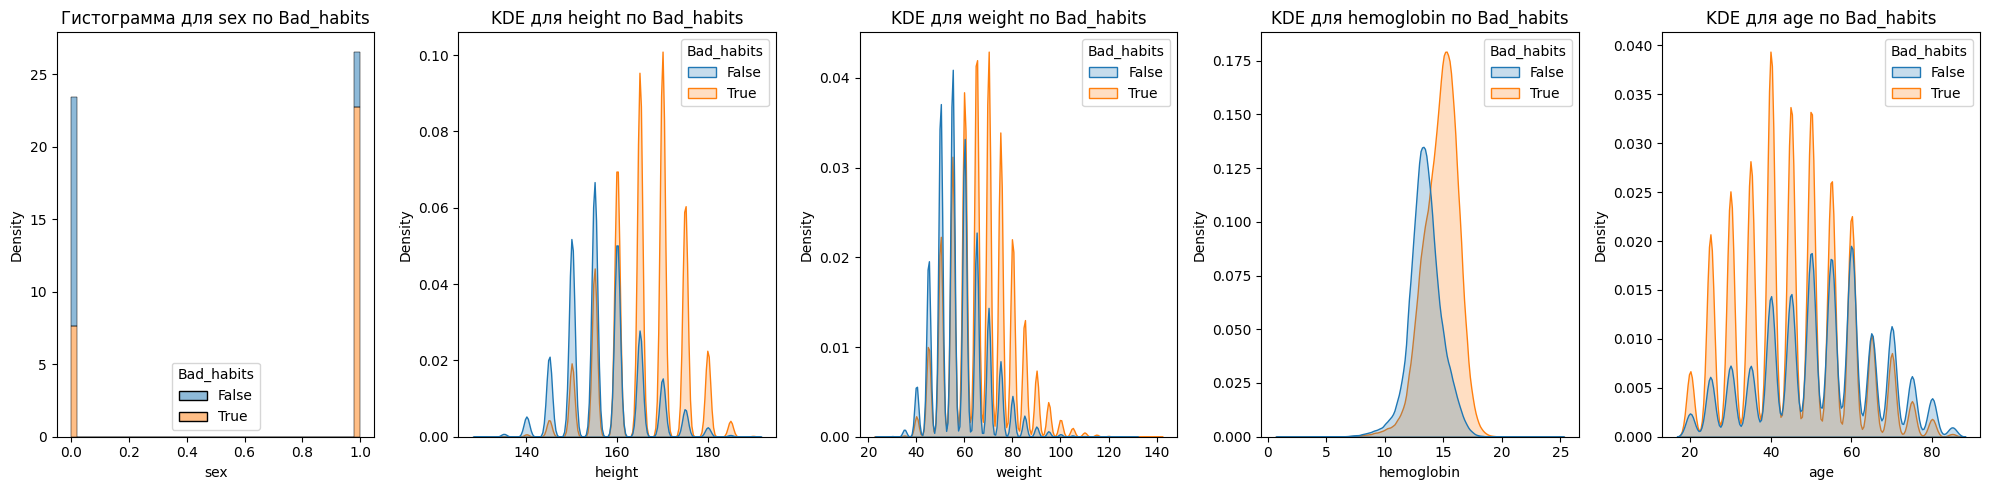

In [ ]:
plt.figure(figsize = (20, 5))

features = ['sex', 'height', 'weight', 'hemoglobin', 'age']
for i, feature in enumerate(features):
    plt.subplot(1, len(features), i + 1)
    if feature == 'sex':
        sns.histplot(data = df, x = feature, hue = 'Bad_habits', multiple = 'stack', stat = 'density', alpha = 0.5)
        plt.title(f'Гистограмма для {feature} по Bad_habits')
    else:
        sns.kdeplot(data = df, x = feature, hue = 'Bad_habits', fill = True)
        plt.title(f'KDE для {feature} по Bad_habits')

plt.tight_layout()
plt.show()

В прошлый раз я решил провести дополнительный анализ на выбранных признаках, но результат оказался хуже, чем при использовании всего датасета. Теперь попробую улучшить результаты, изменив архитектуру нейронной сети, добавив BatchNorm и применив возможности PyTorch Lightning.

#### Общая часть

In [ ]:
!pip install lightning
!pip install tensorboard
!pip install mlflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.2/869.2 kB 56.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 49.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 68.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 106.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 554.1/554.1 kB 37.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
data_features = df[features]
target = df['Bad_habits'].astype(int)

X_train, X_test_valid, y_train, y_test_valid = train_test_split(
    data_features, target, test_size = 0.2, random_state = 42
)

X_valid, X_test, y_valid, y_test = train_test_split(
    X_test_valid, y_test_valid, test_size = 0.5, random_state = 42)

Стандартизируйте данные

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)
X_valid_s = scaler.transform(X_valid)

Далее сформируйте датасет в pytorch-обертке:

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

batch_size = 512

device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'
device

device(type='cuda')

In [ ]:
X_train_t = torch.from_numpy(X_train_s).to(torch.float32).to(device)
X_test_t  = torch.from_numpy(X_test_s ).to(torch.float32).to(device)
X_val_t   = torch.from_numpy(X_valid_s).to(torch.float32).to(device)

y_train_t = torch.from_numpy(np.array(y_train)).to(torch.float32).to(device)
y_test_t  = torch.from_numpy(np.array(y_test )).to(torch.float32).to(device)
y_val_t   = torch.from_numpy(np.array(y_valid)).to(torch.float32).to(device)

train_dataset = TensorDataset(X_train_t, y_train_t)
test_dataset = TensorDataset(X_test_t, y_test_t)
val_dataset = TensorDataset(X_val_t, y_val_t)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, drop_last=True)

Зададим базовый класс модели:

In [ ]:
class MySimpleModel(nn.Module):
    def __init__(self):
        '''
        Здесь объявляем все слои, которые будем использовать
        '''
        super(MySimpleModel, self).__init__()
        self.linear1 = nn.Linear(5, 256)
        self.linear2 = nn.Linear(256, 64)
        self.linear3 = nn.Linear(64, 1)

    def forward(self, x):
        '''
        Здесь пишем в коде, в каком порядке какой слой будет применяться
        '''
        x = self.linear1(nn.Flatten()(x))
        x = self.linear2(nn.ReLU()(x))
        x = self.linear3(nn.ReLU()(x))
        return x.squeeze()

Теперь начнем использовать преимущества Lightning:

In [ ]:
import lightning.pytorch as pl
from torchmetrics.classification import BinaryAUROC
from lightning.pytorch import loggers as pl_loggers
from lightning.pytorch.callbacks import Callback, ModelCheckpoint, DeviceStatsMonitor, EarlyStopping

In [ ]:
class MySimpleModelLightning(pl.LightningModule):
    def __init__(self, lr=0.01, n_classes=2):
        super().__init__()

        self.criterion = nn.BCEWithLogitsLoss()
        self.lr = lr
        self.n_classes = n_classes
        self.save_hyperparameters()
        self.model = MySimpleModel()
        self.roc_auc = BinaryAUROC()

    def forward(self, x):
        '''Forward pass'''
        return self.model(x)

    def training_step(self, batch, batch_idx):
        '''Возвращает лосс с 1 шага обучения по батчу'''
        preds_prob, loss, roc_auc = self.__get_preds_loss_roc_auc(batch)

        # Логируем лосс и метрики
        self.log('train_loss', loss)
        self.log('train_roc_auc', roc_auc)
        return loss

    def validation_step(self, batch, batch_idx):
        '''Используется для логирования метрик'''
        preds_prob, loss, roc_auc = self.__get_preds_loss_roc_auc(batch)

        # Логируем лосс и метрики
        self.log('val_loss', loss)
        self.log('val_roc_auc', roc_auc)

        # Возвращаем предсказания, чтобы использовать их в callback
        return preds_prob

    def test_step(self, batch, batch_idx):
        '''Шаг тестирования'''
        preds_prob, loss, roc_auc = self.__get_preds_loss_roc_auc(batch)
        self.log('test_loss', loss)
        self.log('test_roc_auc', roc_auc)
        return preds_prob

    def configure_optimizers(self):
        '''Определяет оптимизатор модели'''
        return torch.optim.Adam(self.parameters(), lr=self.lr)

    def __get_preds_loss_roc_auc(self, batch):
        '''Вспомогательная функция для шага обучения / валидации'''
        x, y = batch
        logits = self(x)
        preds_prob = torch.sigmoid(logits)  # Получаем вероятности
        preds_class = (preds_prob > 0.5).float()  # Классы
        loss = self.criterion(logits, y)
        roc_auc = self.roc_auc(preds_prob, y.int())

        return preds_class, loss, roc_auc

Инициализация логгеров:

In [ ]:
tb_logger = pl_loggers.TensorBoardLogger(save_dir="lightning_logs/")

In [ ]:
# инициализируем модель
simple_model = MySimpleModelLightning()

# Создаем чекпоинтер
roc_auc_checkpoint_callback = ModelCheckpoint(monitor='val_roc_auc', mode='max')
# Создаем мониторинг ресурсов
device_stats = DeviceStatsMonitor()
# Создаем коллбек для остановки обучения в случае отсутствия улучшений:
early_stopping = EarlyStopping('val_loss')

Создаем Trainer: нужно указать логгер, все функции callback, ускоритель и количество эпох.

In [ ]:
trainer = pl.Trainer(
    logger=tb_logger,
    callbacks=[roc_auc_checkpoint_callback,
               early_stopping,
               device_stats],
    accelerator="gpu",
    max_epochs=30)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Осталось обучить модель с помощью `train.fit`:

In [ ]:
trainer.fit(simple_model, train_dataloader, val_dataloader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | criterion | BCEWithLogitsLoss | 0      | train
1 | model     | MySimpleModel     | 18.0 K | train
2 | roc_auc   | BinaryAUROC       | 0      | train
--------------------------------------------------------
18.0 K    Trainable params
0         Non-trainable params
18.0 K    Total params
0.072     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | criterion | BCEWithLogitsLoss | 0      | train
1 | model     | MySimpleModel     | 18.0 K | train
2 | roc_auc   | BinaryAUROC       | 0      | train
------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [2]:
# Интерактивный просмотр логов
# %reload_ext tensorboard
# %tensorboard --logdir=lightning_logs/

In [ ]:
trainer.test(simple_model, test_dataloader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.47401562333106995    │
│       test_roc_auc        │     0.843026340007782     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.47401562333106995, 'test_roc_auc': 0.843026340007782}]

В целом получили те же результаты, что и в прошлой домашке. Это радует, значит мы нигде не ошиблись. Давайте улучшим архитектуру сети:

In [ ]:
class MyEnhancedModel(nn.Module):
    def __init__(self):
        '''
        Здесь объявляем все слои, которые будем использовать
        '''
        super(MyEnhancedModel, self).__init__()

        self.linear1 = nn.Linear(5, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.dropout1 = nn.Dropout(0.2)

        self.linear2 = nn.Linear(256, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(0.2)

        self.linear3 = nn.Linear(64, 1)

    def forward(self, x):
        '''
        Здесь пишем в коде, в каком порядке какой слой будет применяться
        '''
        x = self.dropout1(nn.ReLU()(self.bn1(self.linear1(nn.Flatten()(x)))))
        x = self.dropout2(nn.ReLU()(self.bn2(self.linear2(x))))
        x = self.linear3(x)

        return x.squeeze()

In [ ]:
class MyEnhancedModelLightning(pl.LightningModule):
    def __init__(self, lr=0.01, n_classes=2):
        super().__init__()

        self.criterion = nn.BCEWithLogitsLoss()
        self.lr = lr
        self.n_classes = n_classes
        self.save_hyperparameters()
        self.model = MyEnhancedModel()
        self.roc_auc = BinaryAUROC()

    def forward(self, x):
        '''Forward pass'''
        return self.model(x)

    def training_step(self, batch, batch_idx):
        '''Возвращает лосс с 1 шага обучения по батчу'''
        preds_prob, loss, roc_auc = self.__get_preds_loss_roc_auc(batch)

        # Логируем лосс и метрики
        self.log('train_loss', loss)
        self.log('train_roc_auc', roc_auc)
        return loss

    def validation_step(self, batch, batch_idx):
        '''Используется для логирования метрик'''
        preds_prob, loss, roc_auc = self.__get_preds_loss_roc_auc(batch)

        # Логируем лосс и метрики
        self.log('val_loss', loss)
        self.log('val_roc_auc', roc_auc)

        # Возвращаем предсказания, чтобы использовать их в callback
        return preds_prob

    def test_step(self, batch, batch_idx):
        '''Шаг тестирования'''
        preds_prob, loss, roc_auc = self.__get_preds_loss_roc_auc(batch)
        self.log('test_loss', loss)
        self.log('test_roc_auc', roc_auc)
        return preds_prob

    def configure_optimizers(self):
        '''Определяет оптимизатор модели'''
        return torch.optim.Adam(self.parameters(), lr=self.lr)

    def __get_preds_loss_roc_auc(self, batch):
        '''Вспомогательная функция для шага обучения / валидации'''
        x, y = batch
        logits = self(x)
        preds_prob = torch.sigmoid(logits)  # Получаем вероятности
        preds_class = (preds_prob > 0.5).float()  # Классы
        loss = self.criterion(logits, y)
        roc_auc = self.roc_auc(preds_prob, y.int())

        return preds_class, loss, roc_auc

In [ ]:
tb_logger = pl_loggers.TensorBoardLogger(save_dir="lightning_logs/exp1/")

# Инициализация модели
model_exp1 = MyEnhancedModelLightning(lr=0.01)

# Чекпоинт для сохранения модели с максимальным ROC-AUC
roc_auc_checkpoint_callback = ModelCheckpoint(monitor='val_roc_auc', mode='max')

# Мониторинг использования устройства (GPU)
device_stats = DeviceStatsMonitor()

# Ранняя остановка, если валидационный лосс не улучшается
early_stopping = EarlyStopping(monitor='val_loss')

# Инициализация тренера
trainer_exp1 = pl.Trainer(
    logger=tb_logger,
    callbacks=[roc_auc_checkpoint_callback, early_stopping, device_stats],
    accelerator="gpu",
    max_epochs=30
)

# Запуск обучения
trainer_exp1.fit(model_exp1, train_dataloader, val_dataloader)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | criterion | BCEWithLogitsLoss | 0      | train
1 | model     | MyEnhancedModel   | 18.7 K | train
2 | roc_auc   | BinaryAUROC       | 0      | train
--------------------------------------------------------
18.7 K    Trainable params
0         Non-trainable params
18.7 K    Total params
0.075     Total estimated model params size (MB)
10        Modules in train mode
0  

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [1]:
# Интерактивный просмотр логов
# %reload_ext tensorboard
# %tensorboard --logdir=lightning_logs/

In [ ]:
trainer_exp1.test(model_exp1, test_dataloader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     0.47480508685112      │
│       test_roc_auc        │    0.8430182337760925     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.47480508685112, 'test_roc_auc': 0.8430182337760925}]

**Выводы:**

На первый взгляд может показаться странным, что вторая модель с добавлением Batch Normalization и Dropout показала немного худшие результаты, чем первая. Вот несколько причин, почему это может происходить:

1. **Регуляризация через Dropout**: Dropout помогает избежать переобучения, отключая случайные нейроны во время тренировки. Но если данные не слишком сложные или модель не переобучается, использование высокого значения Dropout (например, 50%) может мешать ей научиться важным зависимостям.

2. **Batch Normalization**: Этот метод помогает ускорить обучение и сделать его более стабильным. Однако в небольших моделях его влияние может быть непредсказуемым. Иногда он может вызвать незначительные колебания в результатах или даже усложнить обучение.

3. **Стабильность результатов**: Результаты могут варьироваться из-за случайного характера обучения. Разница в метриках между моделями незначительна и может быть частью обычных флуктуаций, связанных с тренировочными и тестовыми данными.

**Итог**: Наша основная цель заключалась в изучении PyTorch Lightning и использовании Batch Normalization, и мы успешно справились с этой задачей, получив неплохие результаты.

### Задача 2.

На семинаре вы уже познакомились с основными методами оптимизации, которые широко используются в классическом машинном обучении. С развитием нейронных сетей и активным внедрением нейросетевого подхода, методы оптимизации стали ещё более актуальными. Но стандартные методы оптимизации, SGD и метод тяжёлого шара, имеют ряд недостатков, из-за чего их редко применяют в чистом виде. Для обучения современных нейросетей используют более продвинутые методы.

В данной задаче вам предстоит самостоятельно реализовать различные оптимизаторы (запущенные из одной точки) и сравнить скорости их сходимости.

Пусть задача оптимизации имеет вид $f(x) \longrightarrow \min\limits_x$, и $\nabla_{x} f(x)$ &mdash; градиент функции $f(x)$.

In [ ]:
! apt-get install imagemagick

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fonts-droid-fallback fonts-noto-mono fonts-urw-base35 ghostscript gsfonts imagemagick-6-common
  imagemagick-6.q16 libdjvulibre-text libdjvulibre21 libfftw3-double3 libgs9 libgs9-common libidn12
  libijs-0.35 libjbig2dec0 libjxr-tools libjxr0 liblqr-1-0 libmagickcore-6.q16-6
  libmagickcore-6.q16-6-extra libmagickwand-6.q16-6 libnetpbm10 libwmflite-0.2-7 netpbm
  poppler-data
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf fonts-texgyre ghostscript-x imagemagick-doc
  autotrace cups-bsd | lpr | lprng enscript gimp gnuplot grads hp2xx html2ps libwmf-bin mplayer
  povray radiance sane-utils texlive-base-bin transfig ufraw-batch libfftw3-bin libfftw3-dev
  inkscape poppler-utils fonts-japanese-mincho | fonts-ipafont-mincho fonts-japanese-gothic
  | fonts-ipafont-gothic fonts-arphic-ukai fonts-arphic-uming fonts-nan

#### 1. SGD

Обычный и стохастический градиентный спуск.

$$x_{t + 1} = x_t - \eta v_t,$$

где $v_{t} = \nabla f(x_{t})$ &mdash; аналогия со скоростью.

In [ ]:
def sgd(init_parameters, func_grad, lr, n_iter):
    '''
    Метод оптимизации SGD.

    Параметры:
    - parameters - начальное приближение параметров,
    - func_grad - функция, задающая градиент оптимизируемой функции,
    - lr - скорость обучения,
    - n_iter - количество итераций метода.

    Возвращает историю обновлений параметров.
    '''

    parameters = init_parameters.copy()
    history = [parameters.copy()]

    for i in range(n_iter):
        parameters -= lr * func_grad(parameters)
        history.append(parameters.copy())

    return history

#### 2. SGD + Momentum

Сгладим градиент, используя информацию о том, как градиент изменялся раньше.
Физическая аналогия &mdash; добавляем инерцию.


$$x_{t + 1} = x_t + v_{t},$$
где $v_{t} = \mu v_{t - 1} - \eta \nabla f(x_{t})$ &mdash; сглаживаем градиенты.

In [ ]:
def sgd_momentum(init_parameters, func_grad, lr, mu, n_iter):
    '''
    Метод оптимизации SGD Momentum.

    Параметры:
    - parameters - начальное приближение параметров,
    - func_grad - функция, задающая градиент оптимизируемой функции,
    - lr - скорость обучения,
    - mu - коэффициент сглаживания,
    - n_iter - количество итераций метода.

    Возвращает историю обновлений параметров.
    '''
    parameters = init_parameters.copy()
    history = [parameters.copy()]

    v = 0

    for i in range(n_iter):
        v = mu * v - lr*func_grad(parameters)
        parameters += v
        history.append(parameters.copy())

    return history

#### 3. Adagrad

Adagrad &mdash; один из самых первых адаптивных методов оптимизации.

Во всех изученных ранее методах есть необходимость подбирать шаг метода (коэффициент $\eta$). На каждой итерации все компоненты градиента оптимизируемой функции домножаются на одно и то же число $\eta$. Но использовать одно значение $\eta$ для всех параметров не оптимально, так как они имеют различные распределения и оптимизируемая функция изменяется с совершенно разной скоростью при небольших изменениях разных параметров.

Поэтому гораздо логичнее **изменять значение каждого параметра с индивидуальной скоростью**. При этом, *чем c большей степени от изменения параметра меняется значение оптимизируемой функции, тем с меньшей скоростью стоить обновлять этот параметр*. Иначе высок шанс расходимости метода. Получить такой результат удается, если разделить градиент на сумму квадратов скорости изменений параметров.

Пусть $x^{(i)}$ &mdash; $i$-я компонента вектора $x$.
$$x_{t+1, i} = x_{t, i} - \frac{\eta}{\sqrt{g_{t, i}+\varepsilon}}\cdot \nabla f_i(x_t)$$
$$g_{t} = g_{t-1} + \nabla f(x_t) \odot \nabla f(x_t)$$


В матрично-векторном виде шаг алгоритма можно переписать так:
$$x_{t+1} = x_{t} - \frac{\eta}{\sqrt{g_{t} + \varepsilon}}\odot \nabla f(x_t).$$
Здесь $\odot$ обозначает произведение Адамара, т.е. поэлементное перемножение векторов.

In [ ]:
def adagrad(init_parameters, func_grad, lr, eps, n_iter):
    '''
    Метод оптимизации Adagrad.

    Параметры:
    - parameters - начальное приближение параметров,
    - func_grad - функция, задающая градиент оптимизируемой функции,
    - lr - скорость обучения,
    - eps - минимальное значение нормирующего члена,
    - n_iter - количество итераций метода.

    Возвращает историю обновлений параметров.
    '''
    parameters = init_parameters.copy()
    history = [parameters.copy()]

    g = 0

    for iter_id in range(n_iter):
        grad = func_grad(parameters)
        g += grad**2
        parameters -= lr / (g + eps) ** 0.5 * grad
        history.append(parameters.copy())

    return history

#### 4. RMSProp

Алгоритм RMSProp основан на той же идее, что и алгоритм Adagrad &mdash; адаптировать learning rate отдельно для каждого параметра $\theta^{(i)}$.  Однако Adagrad имеет серьёзный недостаток. Он с одинаковым весом учитывает квадраты градиентов как с самых первых итераций, так и с самых последних. Хотя, на самом деле, наибольшую значимость имеют модули градиентов на последних нескольких итерациях.

Для этого предлагается использовать **экспоненциальное сглаживание**.
$$x_{t+1} = x_{t} - \frac{\eta}{\sqrt{g_{t} + \varepsilon}}\odot \nabla f(x_t).$$
$$g_t = \mu g_{t-1} + (1-\mu) \nabla f(x_t) \odot \nabla f(x_t)$$

Стандартные значения гиперпараметров: $\mu = 0.9, \eta = 0.001$.

In [ ]:
def rmsprop(init_parameters, func_grad, lr, mu, eps, n_iter):
    '''
    Метод оптимизации RMSProp.

    Параметры:
    - parameters - начальное приближение параметров,
    - func_grad - функция, задающая градиент оптимизируемой функции,
    - lr - скорость обучения,
    - mu - коэффициент сглаживания,
    - eps - минимальное значение нормирующего члена,
    - n_iter - количество итераций метода.

    Возвращает историю обновлений параметров.
    '''

    parameters = init_parameters.copy()
    history = [parameters.copy()]

    g = 0

    for iter_id in range(n_iter):
        grad = func_grad(parameters)
        g = mu * g + (1 - mu) * grad**2
        parameters -= lr / (g + eps)**0.5 * grad
        history.append(parameters.copy())

    return history

**5. Adam**

Этот алгоритм совмещает в себе 2 идеи:
* идею алгоритма Momentum *о накапливании градиента*,
* идею методов Adadelta и RMSProp *об экспоненциальном сглаживании* информации о предыдущих значениях квадратов градиентов.

Благодаря использованию этих двух идей, метод имеет 2 преимущества над большей частью методов первого порядка, описанных выше:


1. Он обновляет все параметры $\theta$ не с одинаковым `learning rate`, а выбирает для каждого $\theta_i$ индивидуальный `learning rate`, что *позволяет учитывать разреженные признаки с большим весом*.


2. Adam за счёт применения экспоненциального сглаживания к градиенту *работает более устойчиво в окрестности оптимального значения параметра $\theta^*$*, чем методы, использующие градиент в точке $x_t$, не накапливая значения градиента с прошлых шагов.


Формулы шага алгоритма выглядят так:
$$v_{t + 1} = \beta v_{t} + (1-\beta) \nabla x(x_{t})$$
$$g_t = \mu g_{t-1} + (1-\mu) \nabla x(x_t) \odot \nabla x(x_t)$$

Чтобы эти оценки не были смещёнными, нужно их отнормировать:
$$\widehat{v}_{t + 1} = \frac{v_{t + 1}}{1-\beta^t},$$
$$\widehat{g}_t = \frac{g_t}{1-\mu^t}.$$

Тогда получим итоговую формулу шага:

$$x_{t+1} = x_t - \frac{\eta}{\sqrt{\widehat{g}_t + \varepsilon}} \odot \widehat{v}_{t + 1}.$$

In [ ]:
def adam(init_parameters, func_grad, eps, lr, beta, mu,  n_iter):
    '''
    Adam.

    Параметры.
    1) theta0 - начальное приближение theta,
    2) func_grad - функция, задающая градиент оптимизируемой функции,
    3) eps - мин. возможное значение знаменателя,
    4) lr - скорость обучения,
    5) beta - параметр экспоненциального сглаживания,
    6) mu - параметр экспоненциального сглаживания,
    7) n_iter - количество итераций метода.
    '''

    parameters = init_parameters.copy()
    history = [parameters.copy()]

    v, g = 0, 0

    for iter_id in range(n_iter):
        grad = func_grad(parameters)
        v = beta*v + (1 - beta) * grad
        g = mu*g + (1 - mu) * grad**2
        v_hat = v / (1 - beta**iter_id + eps)
        g_hat = g / (1 - mu**iter_id + eps)
        parameters -= lr / (g_hat + eps)**0.5 * v_hat
        history.append(parameters.copy())

    return history

Сравнение оптимизаторов будем производить на примере двух функций:
1. $f(x, y) = 5*x^2 + y^2$
2. $f(x, y) = (x-3)^2 + 8(y-5)^4 + \sqrt{x} + \sin(xy)$

Реализуйте данные функции в ячейке ниже для удобства и читаемости кода.

In [ ]:
def square_sum(x):
    ''' f(x, y) = 5 * x^2 + y^2 '''

    return 5 * x[0]**2 + x[1]**2

def square_sum_grad(x):
    ''' grad f(x, y) = <..> '''

    return np.array([10 * x[0], 2 * x[1]])


def complex_sum(x):
    ''' f(x, y) = (x-3)^2 + 8(y-5)^4 + sqrt(x) + sin(xy)'''

    return (x[0] - 3)**2 + 8 * (x[1] - 5)**4 + x[0]**0.5 + np.sin(x[0] * x[1])

def complex_sum_grad(x, eps=1e-7):
    ''' grad f(x, y) = <..> '''

    partial_x = 2 * (x[0] - 3) + 1 / (2 * x[0]**0.5 + eps) + x[1] * np.cos(x[0] * x[1])
    partial_y = 32 * (x[1] - 5)**3 + x[0] * np.cos(x[0] * x[1])

    return np.array([partial_x, partial_y])

Создадим директорию, в которой будем хранить визуализацию экспериментов.

In [ ]:
!rm -rf saved_gifs
!mkdir saved_gifs

Напишем функцию, которая будет отрисовывать процесс оптимизации.

In [ ]:
def make_experiment(func, trajectory, graph_title,
                    min_y=-7, max_y=7, min_x=-7, max_x=7):
    '''
    Функция, которая для заданной функции рисует её линии уровня,
    а также траекторию сходимости метода оптимизации.

    Параметры.
    1) func - оптимизируемая функция,
    2) trajectory - траектория метода оптимизации,
    3) graph_name - заголовок графика.
    '''

    fig, ax = plt.subplots(figsize=(10, 8))
    xdata, ydata = [], []
    ln, = plt.plot([], [])

    mesh_x = np.linspace(min_x, max_x, 300)
    mesh_y = np.linspace(min_y, max_y, 300)
    X, Y = np.meshgrid(mesh_x, mesh_y)
    Z = np.zeros((len(mesh_x), len(mesh_y)))

    for coord_x in range(len(mesh_x)):
        for coord_y in range(len(mesh_y)):
            Z[coord_y, coord_x] = func(
                np.array((mesh_x[coord_x],
                          mesh_y[coord_y]))
            )

    def init():
        ax.contour(
            X, Y, np.log(Z),
            np.log([0.5, 10, 30, 80, 130, 200, 300, 500, 900]),
            cmap='winter'
        )
        ax.set_title(graph_title)
        return ln,

    def update(frame):
        xdata.append(trajectory[frame][0])
        ydata.append(trajectory[frame][1])
        ln.set_data(xdata, ydata)
        return ln,

    ani = FuncAnimation(
        fig, update, frames=range(len(trajectory)),
        init_func=init, repeat=True
    )
    writer = ImageMagickFileWriter(fps=10)
    ani.save(f'saved_gifs/{graph_title}.gif',
             writer=writer)
    plt.show()

### Простая функция $f(x, y) = x^2 + y^2$

In [ ]:
parameters = np.array((5, 5), dtype=float)
func_name = '$f(x, y) = 5x^2 + y^2$'
func_grad = square_sum_grad
func = square_sum
n_iter = 100

**SGD**

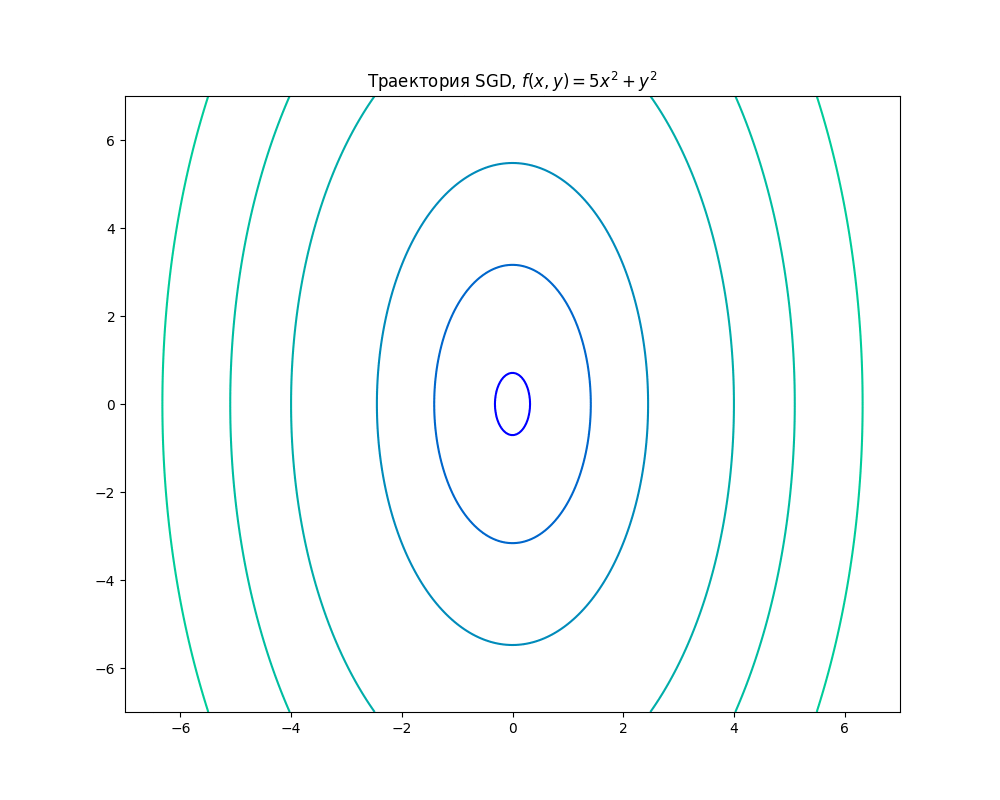

In [ ]:
sgd_trajectory = sgd(
    init_parameters=parameters,
    func_grad=func_grad,
    lr=0.05,
    n_iter=n_iter
)
graph_title = 'Траектория SGD, ' + func_name
make_experiment(
    func,
    sgd_trajectory,
    graph_title,
)
clear_output()
Image(open(f'saved_gifs/{graph_title}.gif','rb').read())

**SGD Momentum**

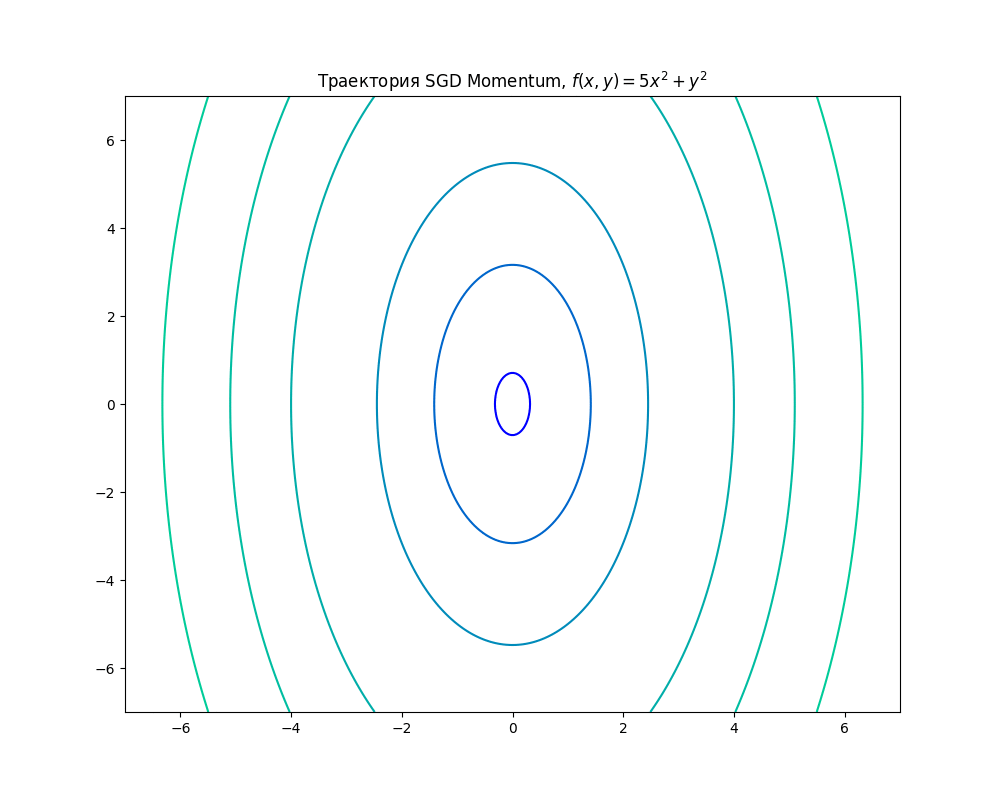

In [ ]:
sgd_momentum_trajectory = sgd_momentum(
    init_parameters=parameters.copy(),
    func_grad=func_grad,
    lr=0.01,
    n_iter=n_iter,
    mu=0.9
)
graph_title = 'Траектория SGD Momentum, ' + func_name
make_experiment(
    func,
    sgd_momentum_trajectory,
    graph_title,
)
clear_output()
Image(open(f'saved_gifs/{graph_title}.gif','rb').read())

**Adagrad**

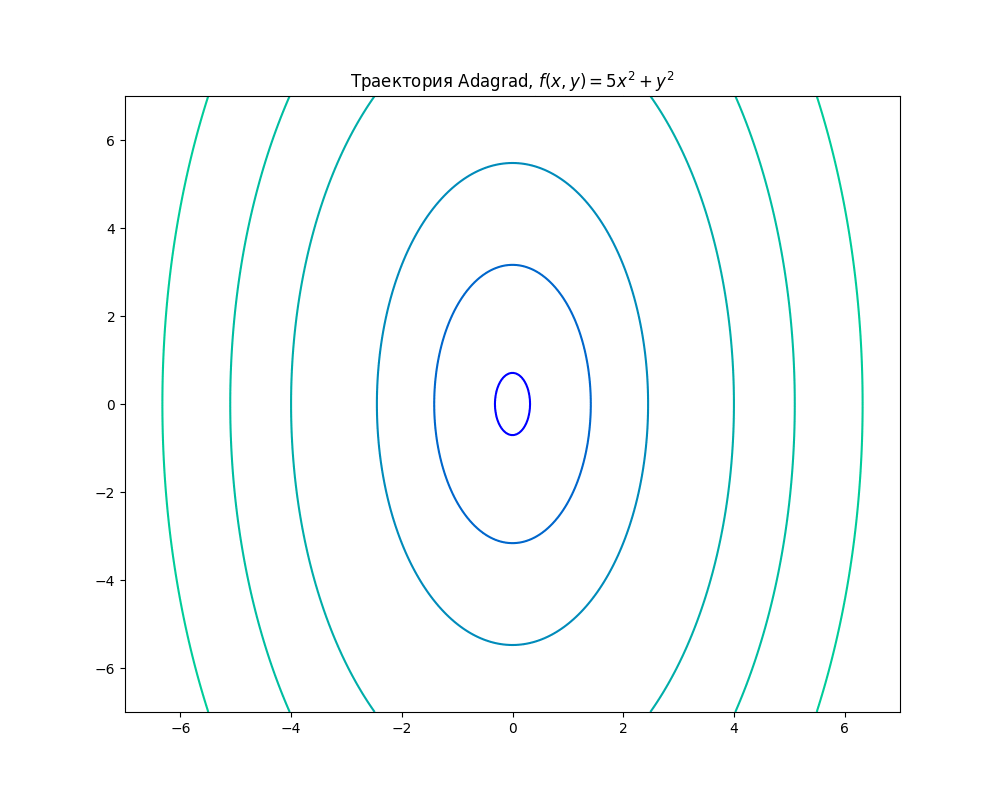

In [ ]:
adagrad_trajectory = adagrad(
    init_parameters=parameters.copy(),
    func_grad=func_grad,
    lr=0.8,
    n_iter=n_iter,
    eps=1e-6,
)
graph_title = 'Траектория Adagrad, ' + func_name
make_experiment(
    func,
    adagrad_trajectory,
    graph_title,
)
clear_output()
Image(open(f'saved_gifs/{graph_title}.gif','rb').read())

**RMSProp**

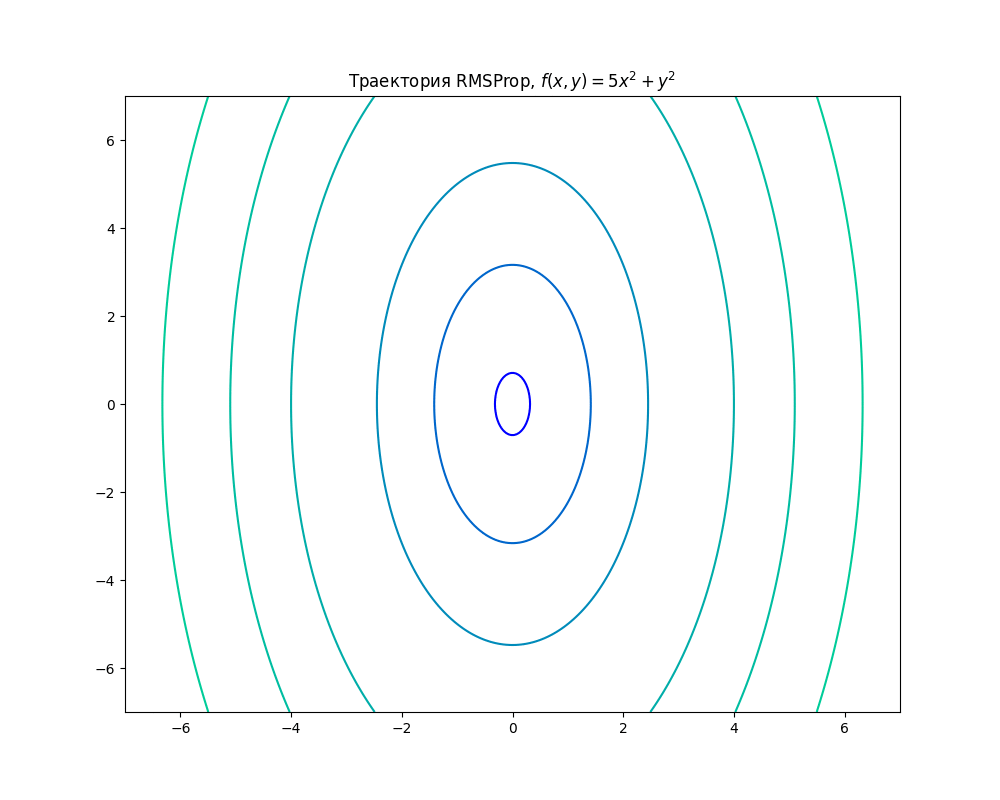

In [ ]:
rmsprop_trajectory = rmsprop(
    init_parameters=parameters.copy(),
    func_grad=func_grad,
    lr=0.1,
    n_iter=n_iter,
    eps=1e-6,
    mu=0.9
)
graph_title = 'Траектория RMSProp, ' + func_name
make_experiment(
    func,
    rmsprop_trajectory,
    graph_title,
)
clear_output()
Image(open(f'saved_gifs/{graph_title}.gif','rb').read())

**Adam**

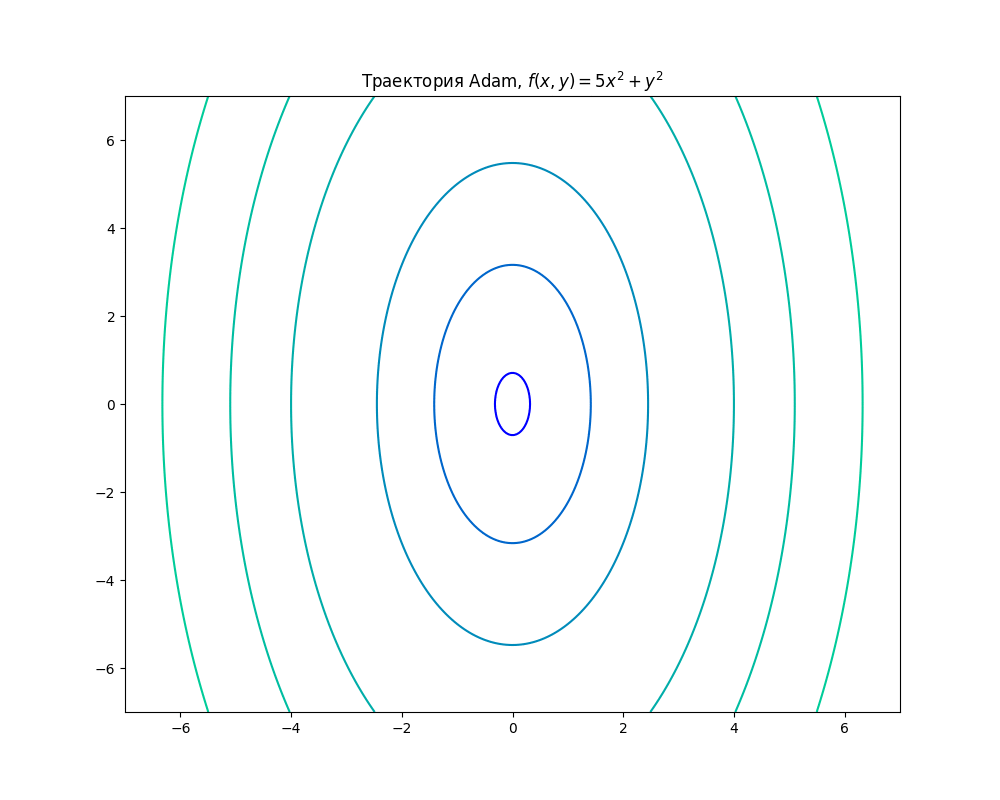

In [ ]:
adam_trajectory = adam(
    init_parameters=parameters.copy(),
    func_grad=func_grad,
    lr=0.03,
    n_iter=n_iter,
    eps=1e-6,
    mu=0.9,
    beta=0.99
)
graph_title = 'Траектория Adam, ' + func_name
make_experiment(
    func,
    adam_trajectory,
    graph_title,
)
clear_output()
Image(open(f'saved_gifs/{graph_title}.gif','rb').read())

**Вывод**

### Сложная функция $f(x, y) = (x-3)^2 + 8(y-5)^4 + \sqrt{x} + \sin(xy)$

In [ ]:
parameters = np.array((5, -2), dtype=float)
func_name = '$f(x, y) = (x-3)^2 + 8(y-5)^4 + \sqrt{x} + \sin(xy)$'
func_grad = complex_sum_grad
func = complex_sum
n_iter = 100

**SGD**

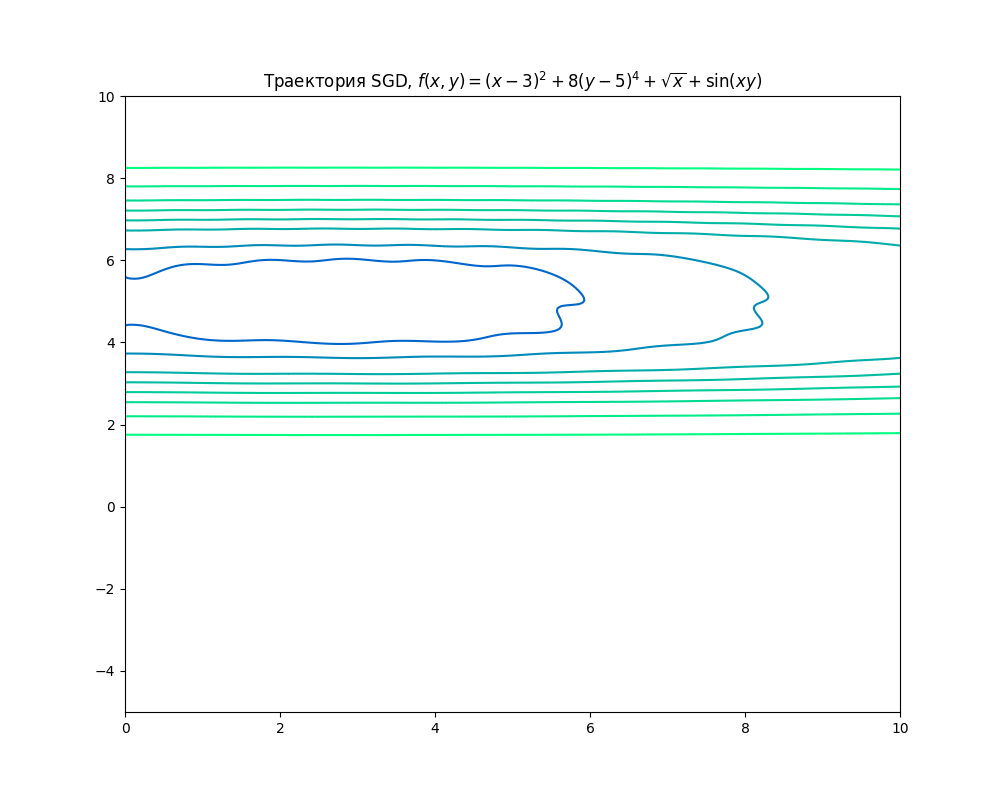

In [ ]:
sgd_trajectory = sgd(
    init_parameters=parameters,
    func_grad=func_grad,
    lr=0.0006,
    n_iter=n_iter
)
graph_title = 'Траектория SGD, ' +  func_name
make_experiment(
    func,
    sgd_trajectory,
    graph_title,
    -5, 10, 0, 10
)
clear_output()
Image(open(f'saved_gifs/{graph_title}.gif','rb').read())

**SGD Momentum**

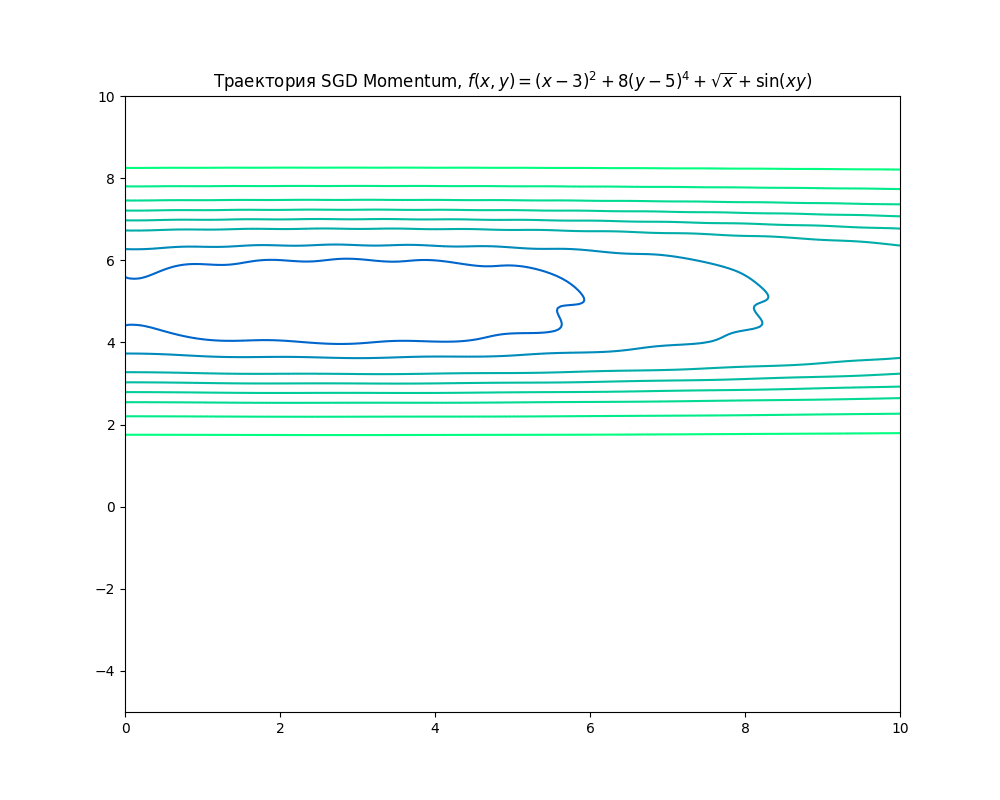

In [ ]:
sgd_momentum_trajectory = sgd_momentum(
    init_parameters=parameters.copy(),
    func_grad=func_grad,
    lr=0.0002,
    n_iter=n_iter,
    mu=0.7
)
graph_title = 'Траектория SGD Momentum, ' +  func_name
make_experiment(
    func,
    sgd_momentum_trajectory,
    graph_title,
    -5, 10, 0, 10
)
clear_output()
Image(open(f'saved_gifs/{graph_title}.gif','rb').read())

**Adagrad**

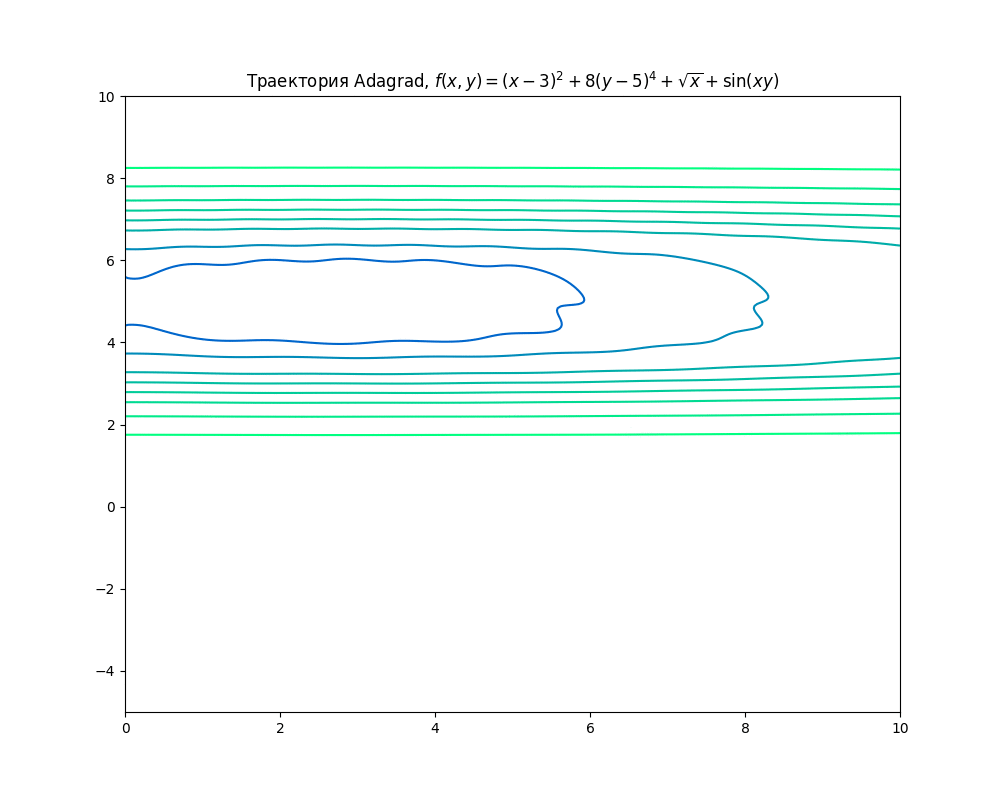

In [ ]:
adagrad_trajectory = adagrad(
    init_parameters=parameters.copy(),
    func_grad=func_grad,
    lr=2.0,
    n_iter=n_iter,
    eps=1e-6,
)
graph_title = 'Траектория Adagrad, ' + func_name
make_experiment(
    func,
    adagrad_trajectory,
    graph_title,
    -5, 10, 0, 10
)
clear_output()
Image(open(f'saved_gifs/{graph_title}.gif','rb').read())

**RMSProp**

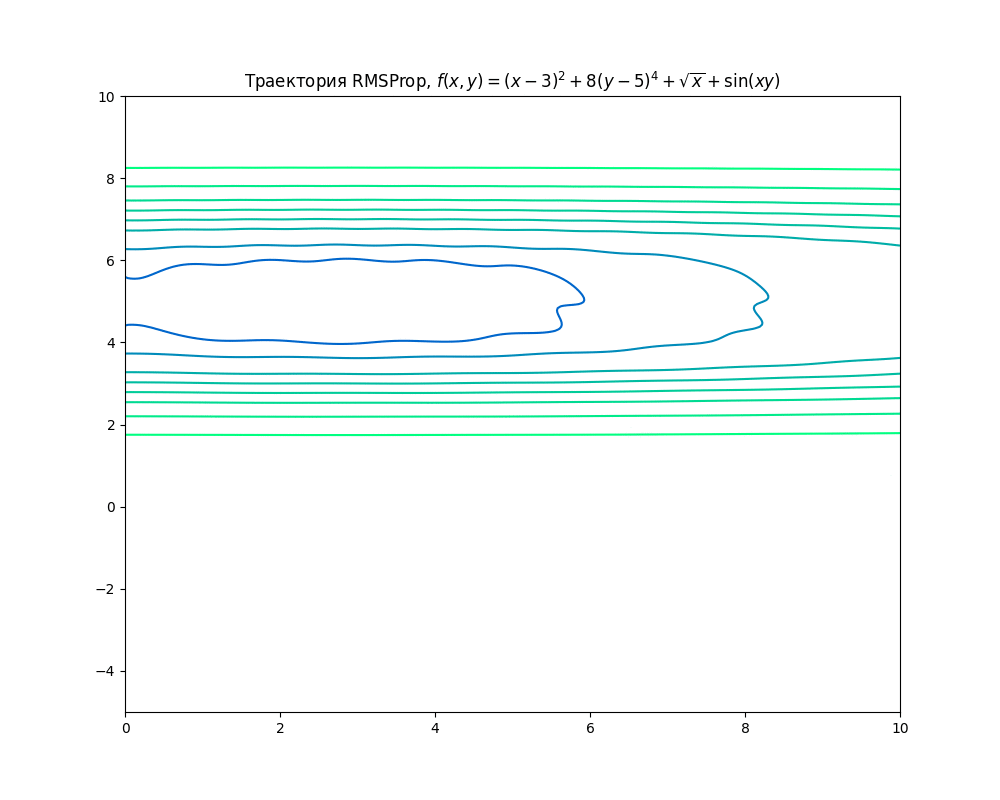

In [ ]:
rmsprop_trajectory = rmsprop(
    init_parameters=parameters.copy(),
    func_grad=func_grad,
    lr=0.3,
    n_iter=n_iter,
    eps=1e-6,
    mu=0.9
)
graph_title = 'Траектория RMSProp, ' + func_name
make_experiment(
    func,
    rmsprop_trajectory,
    graph_title,
    -5, 10, 0, 10
)
clear_output()
Image(open(f'saved_gifs/{graph_title}.gif','rb').read())

**Adam**

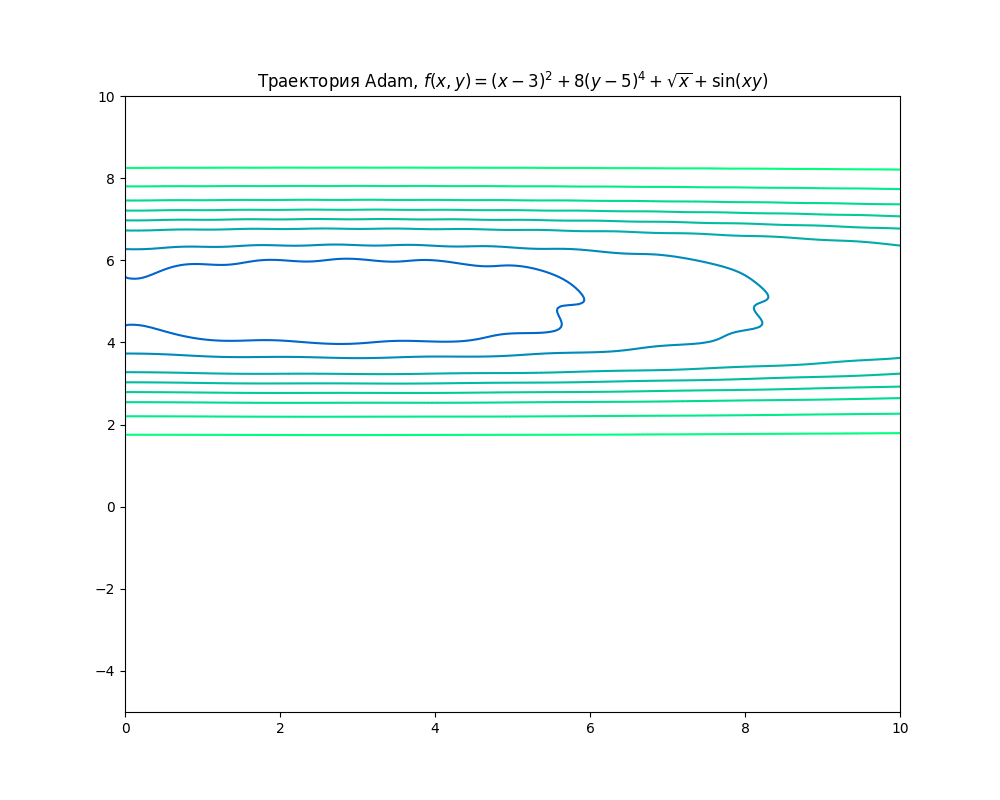

In [ ]:
adam_trajectory = adam(
    init_parameters=parameters.copy(),
    func_grad=func_grad,
    lr=0.008,
    n_iter=n_iter,
    eps=1e-7,
    mu=0.7,
    beta=0.9
)
graph_title = 'Траектория Adam, ' + func_name
make_experiment(
    func,
    adam_trajectory,
    graph_title,
    -5, 10, 0, 10
)
clear_output()
Image(open(f'saved_gifs/{graph_title}.gif','rb').read())

**Вывод**

1. **SGD и SGD с Momentum**

   Для простой функции видно, что **SGD** и **SGD + Momentum** достигают минимума по более извилистой траектории. **SGD** часто делает большие шаги в направлении градиента, что может привести к колебаниям около минимума. **SGD + Momentum** сглаживает этот процесс, добавляя ускорение, что позволяет стабилизировать траекторию, но всё равно она может быть менее прямолинейной, чем у более продвинутых методов.

   Для сложных функций простые оптимизаторы (SGD и его модификации) могут сходиться быстрее, так как они делают шаги, основанные исключительно на текущем градиенте, не учитывая дополнительные параметры, как это делают более сложные методы. Однако их поведение может оставаться неоптимальным, если требуется высокая точность минимума.

2. **Продвинутые оптимизаторы (Adagrad, RMSProp, Adam)**

   Эти методы учитывают не только текущие значения градиента, но и его историю. **Adagrad** быстро адаптируется к редким признакам, но может замедляться в конце из-за накопления градиентов. **RMSProp** решает эту проблему, стабилизируя обучение, но может требовать точного подбора скорости обучения (`learning rate`). **Adam** комбинирует идеи Momentum и RMSProp, что делает его наиболее универсальным, но и наиболее чувствительным к настройкам гиперпараметров (особенно для сложных функций).

   Для сложных функций **более продвинутые оптимизаторы** часто требуют тщательной настройки параметров, таких как скорость обучения, коэффициенты сглаживания градиентов (например, `beta1`, `beta2` в Adam). Иногда простые значения по умолчанию могут не дать желаемых результатов, и их приходится подбирать вручную для достижения лучшей сходимости.

3. **Подбор параметров**

   Каждому оптимизатору требуется свой подход к настройке гиперпараметров. Например, для одной и той же функции могут значительно различаться оптимальные значения `learning rate` и поведения оптимизаторов. Поэтому важно не полагаться на значения по умолчанию и адаптировать параметры под конкретную задачу.